[*********************100%%**********************]  1 of 1 completed
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1404
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016    
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014    
Epoch 16/20

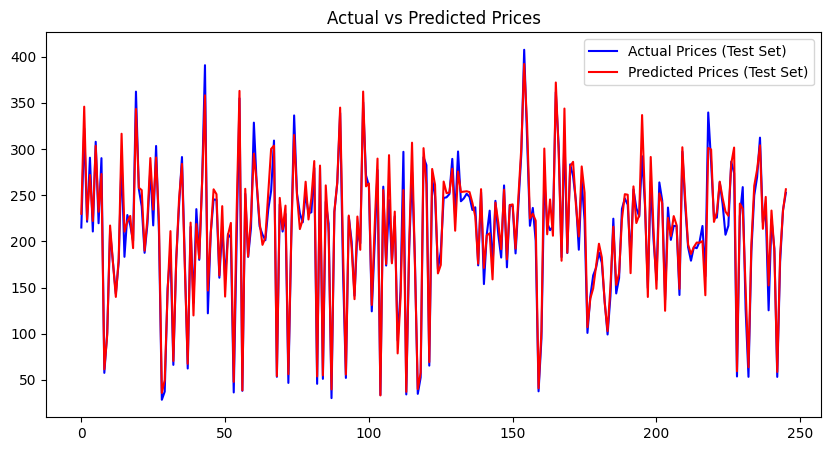

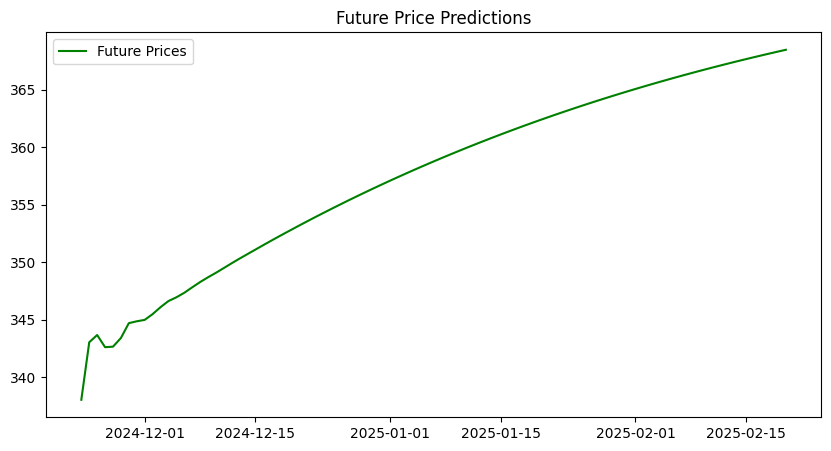

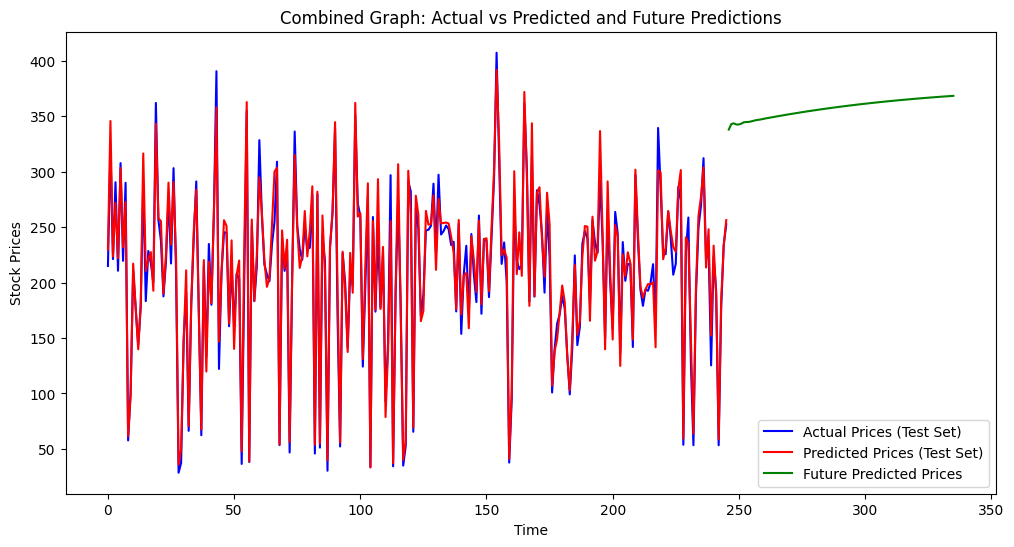

[datetime.datetime(2024, 11, 25, 0, 0), datetime.datetime(2024, 11, 26, 0, 0), datetime.datetime(2024, 11, 27, 0, 0), datetime.datetime(2024, 11, 28, 0, 0)] [343.65826 342.599   342.64478 343.39664]
The predicted stock price for 2025-02-20 is $368.46


In [1]:
from datetime import timedelta
import yfinance as yf
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Step 1: Fetch data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Step 2: Prepare the data with lagged features for LSTM
def prepare_data(data, lag=5):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[['Close']])
    
    X, y = [], []
    for i in range(lag, len(data_scaled)):
        X.append(data_scaled[i-lag:i, 0])
        y.append(data_scaled[i, 0])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y, scaler

# Step 3: Build and train an LSTM model
def train_lstm_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Reshape input for LSTM (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Build LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
    
    y_pred = model.predict(X_test)
    return model, X_train, X_test, y_train, y_test, y_pred

# Step 4: Evaluate model performance
def evaluate_model(y_test, y_pred, scaler):
    # Rescale the predictions and ground truth back to original scale
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")

# Step 5: Predict future prices
def predict_future_prices(model, last_known_data, scaler, lag=5, days=90):
    future_prices = []
    current_data = last_known_data.copy()
    
    for _ in range(days):
        # Reshape input for LSTM prediction
        input_data = current_data.reshape((1, lag, 1))
        next_price = model.predict(input_data)[0, 0]
        
        # Append the predicted price
        future_prices.append(next_price)
        
        # Update current_data for next prediction
        current_data = np.roll(current_data, shift=-1)
        current_data[-1] = next_price
    
    # Inverse transform predictions to original scale
    future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1)).flatten()
    future_dates = [last_date + timedelta(days=i) for i in range(1, days + 1)]
    return future_dates, future_prices

# Step 6: Plot predictions
def plot_results1(y_test, y_pred, scaler):
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_rescaled, label='Actual Prices (Test Set)', color='blue')
    plt.plot(y_pred_rescaled, label='Predicted Prices (Test Set)', color='red')
    plt.legend()
    plt.title('Actual vs Predicted Prices')
    plt.show()

def plot_results2(future_dates, future_prices):
    plt.figure(figsize=(10, 5))
    plt.plot(future_dates, future_prices, label='Future Prices', color='green')
    plt.legend()
    plt.title('Future Price Predictions')
    plt.show()

# Step 6 (New): Plot combined results
def plot_combined_graph(y_test, y_pred, future_dates, future_prices, scaler):
    # Rescale the predictions and actual values to their original scale
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    
    plt.figure(figsize=(12, 6))
    
    # Plot actual vs predicted
    plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual Prices (Test Set)', color='blue')
    plt.plot(range(len(y_pred_rescaled)), y_pred_rescaled, label='Predicted Prices (Test Set)', color='red')
    
    # Append future predictions to the same graph
    future_indices = range(len(y_test_rescaled), len(y_test_rescaled) + len(future_prices))
    plt.plot(future_indices, future_prices, label='Future Predicted Prices', color='green')
    
    plt.title('Combined Graph: Actual vs Predicted and Future Predictions')
    plt.xlabel('Time')
    plt.ylabel('Stock Prices')
    plt.legend()
    plt.show()

# Example usage
if __name__ == "__main__":
    ticker = 'TSLA'  # Example stock ticker
    start_date = '2020-01-01'
    end_date = '2024-11-25'
    
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    X, y, scaler = prepare_data(stock_data, lag=5)
    
    model, X_train, X_test, y_train, y_test, y_pred = train_lstm_model(X, y)
    evaluate_model(y_test, y_pred, scaler)
    
    # Predict future prices
    last_known_data = X[-1]  # Last feature set
    last_date = stock_data.index[-1].to_pydatetime().replace(tzinfo=None)
    future_dates, future_prices = predict_future_prices(model, last_known_data, scaler, lag=5, days=90)
    
    # Plot results
    plot_results1(y_test, y_pred, scaler)
    plot_results2(future_dates, future_prices)
    plot_combined_graph(y_test, y_pred, future_dates, future_prices, scaler)
    
    # Print future prices
    print(future_dates[2:6], future_prices[2:6])
    print(f"The predicted stock price for {future_dates[-1].strftime('%Y-%m-%d')} is ${future_prices[-1]:.2f}")
